In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

In [2]:
vgg = models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:33<00:00, 17395184.59it/s]


In [3]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Preprocessing of the image

In [4]:
imsize = 512
is_cuda = torch.cuda.is_available()

In [5]:
#converting the image making it suitable for training with the vgg model
prep = transforms.Compose([transforms.Resize(imsize) ,
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x : x[torch.LongTensor([2,1,0])]) , #turn it into BGR 
                           transforms.Normalize(mean = [0.40760392 , 0.45795686 , 0.48501961],
                                                std = [1,1,1]),
                           transforms.Lambda(lambda x : x.mul_(255)),
                          ])

In [6]:
#converting the generated image back to a format which we can visualize
postpa = transforms.Compose([transforms.Lambda(lambda x : x.mul_(1./255)),
                            transforms.Normalize(mean = [-0.4076032 , -0.45795686 , -0.48501961] , 
                                                std = [1,1,1]),
                            transforms.Lambda(lambda x : x[torch.LongTensor([2,1,0])]) ,  #turn it back into RGB
                            ])

postpb = transforms.Compose([transforms.ToPILImage()])


In [7]:
#to ensure that the generate image do not cross the permissible range
def postp(tensor):
    t = postpa(tensor)
    t[t > 1] = 1
    t[t < 0] = 0
    img = postpb(t)
    return img

In [8]:
def image_loader(image_name):
    image = Image.open(image_name)        #takes the image and preprocess it for training
    image = Variable(prep(image))
    image = image.unsqueeze(0)          #fake batch dimension required to fit network's input dimension
    return image

In [9]:
def show_image(image , title):
    plt.figure(figsize=(12 , 8))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [10]:
import os
print(os.listdir("../input"))

['images', 'images2']


In [11]:
content_img_path = "../input/images/Content.jpg"
style_img_path = "../input/images/Style Image.jpg"

In [12]:
content = Image.open(content_img_path)
style = Image.open(style_img_path)

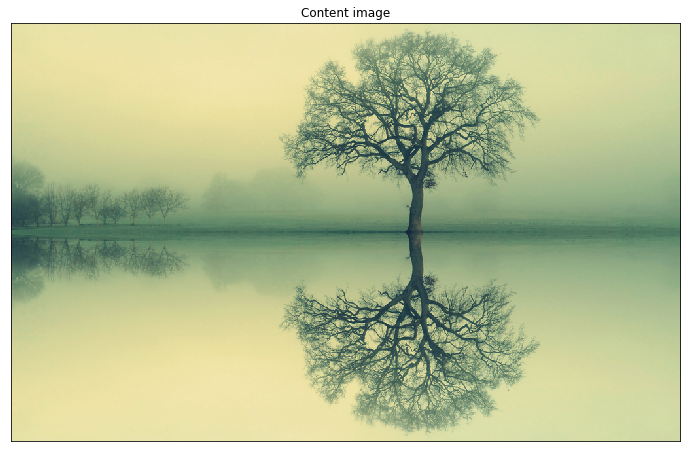

In [13]:
show_image(content , "Content image")

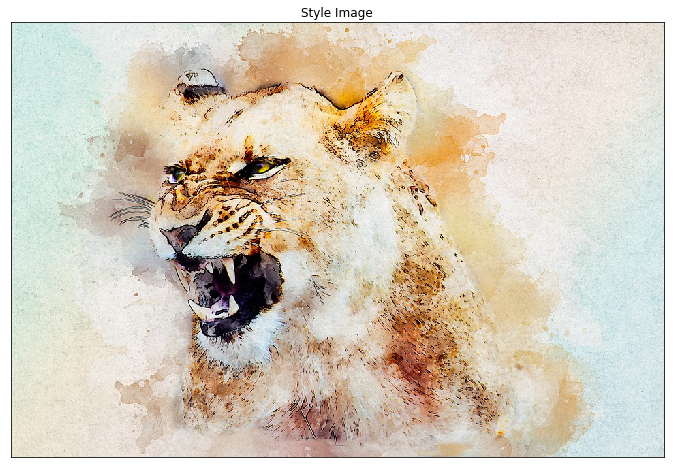

In [14]:
show_image(style , "Style Image")

# Loading the images

In [15]:
style_img = image_loader(style_img_path)
content_img = image_loader(content_img_path)

In [16]:
# show_image(style_img[0][0], "Loaded style image B Channel")

In [17]:
# show_image(content_img[0][2].cpu() , "Loaded content image B channel")

In [18]:
content_img , style_img = content_img.cuda(), style_img.cuda()

In [19]:
opt_img = Variable(content_img.data.clone().cuda() , requires_grad= True)

# Creating the VGG model

In [20]:
vgg_features = vgg.features.cuda()

In [21]:
#Since we are not changing the weights of the vgg model so change requires_grad = False
for param in vgg_features.parameters():
    param.requires_grad = False

# Gram matrix Class

In [22]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)      #So dimension is b * c * (h*w) 
                                            #Gram matrix contains the correlation between different channels of the image
        gram_matrix = torch.bmm(features , features.transpose(1,2))
        gram_matrix.div_(h * w)          #normalizing the image
        return gram_matrix
        

In [23]:
#implemented as the nn.Layer
class styleLoss(nn.Module):
    def forward(self, inputs, targets):         #target is the style values of the style image
        out = nn.MSELoss()(GramMatrix()(inputs) , targets ) #pass the input through the image, gets its loss and compute the mse loss
        return out
    
    
    #GramMatrix()    - creates the class
    #pass the input through that model and get the gram matrix
    
    #Create nn.MSELoss and compute the loss for the style
    

# Extracting the features

In [24]:
class LayerActivations ():
    features = []
    def __init__(self , model , layer_nums):
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
            
    def hook_fn (self , module , input , output):
        self.features.append(output)
        
    def remove(self):
        for hook in self.hooks:
            hook.remove();
        

In [25]:
def extract_layers(layers , img , model = None):
    la = LayerActivations(model , layers)
    
    #clearing the cache
    la.features = []
    out = model(img)
    la.remove()
    return la.features
    

# Extracting the Target

In [26]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [27]:
style_weights = [1000/n**2 for n in [64 , 128 , 256 , 512 , 512]]
content_weights = [1]
weights = style_weights + content_weights

In [28]:
content_targets = extract_layers(content_layers , content_img , model = vgg_features)
style_targets = extract_layers(style_layers , style_img , model = vgg_features)

In [29]:
#detach the targets since we are not changing the content and the style image
content_targets = [t.detach() for t in content_targets]
style_targets = [GramMatrix()(t).detach() for t in style_targets]

In [30]:
#add the targets together
targets = style_targets + content_targets

# Creating the loss functions

In [31]:
loss_fns = [styleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)

# Creating the optimizer

In [32]:
optimizer = optim.LBFGS([opt_img])

# Training the model

In [33]:
max_iter = 500
itr = [0]
while itr[0] <= max_iter:
    
    def closure():
        optimizer.zero_grad()
        out = extract_layers(loss_layers , opt_img , model = vgg_features)
        
        layer_losses = [weights[a] * loss_fns[a](A , targets[a]) for a,A in enumerate(out)]
        
        loss = sum(layer_losses)
        loss.backward()
        itr[0] += 1
        if (itr[0] % 50 == 0):
            print("Iteration :" , itr[0] , " loss : " , loss.item())
        
        return loss
    
    optimizer.step(closure)
        

Iteration : 50  loss :  20880.369140625
Iteration : 100  loss :  7289.107421875
Iteration : 150  loss :  5515.6376953125
Iteration : 200  loss :  5026.01416015625
Iteration : 250  loss :  4773.564453125
Iteration : 300  loss :  4618.16796875
Iteration : 350  loss :  4514.99462890625
Iteration : 400  loss :  4441.67333984375
Iteration : 450  loss :  4386.3271484375
Iteration : 500  loss :  4343.2822265625


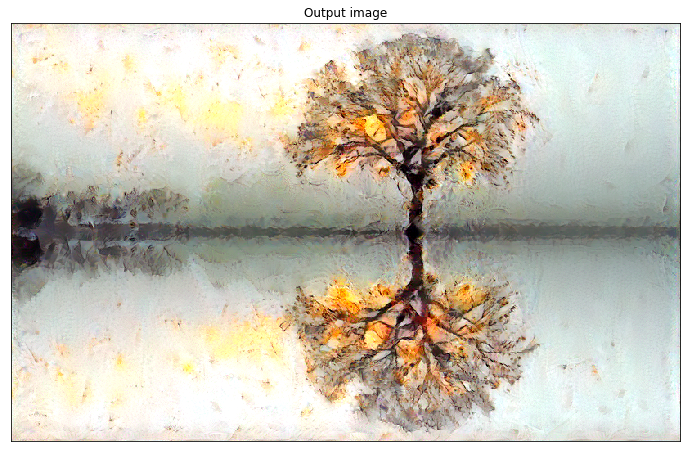

In [34]:
out_img = postp(opt_img.data[0].cpu().squeeze())
show_image(out_img , "Output image")